In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import function_library_assignment_1 as fnc

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

In [2]:
n_bus = 24
S_base_3ph = 100
gen_data = fnc.read_data('gen_data')
demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_data = fnc.read_data('gen_data')
gen_costs = fnc.read_data('gen_costs')
line_data = fnc.read_data('line_data')
branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data')

Setting dictionaries which map bus indices to generator and wind farm indices for easier looping - note that it accounts for zero-indexing, so the generator indices go from 0 to 11

In [3]:
gens_map, wf_map = fnc.mapping_dictionaries(gen_data)

gens_map.get(14) #example: get the generator indices at bus 14 (15 in the assignment formulation)

[4, 5]

# Task 1 (single time step)

### Setup model and solve

* Be aware that power values (also loads) need to be in per-unit
* P_min of the generators can be set to 0
* Only use day-ahead costs and disregard ramping

In [4]:
t = 0 #hour
load = np.zeros(n_bus)

#Saving the load for each bus in a numpy array accounting for the system load destribution
for n in load_distribution['Node'].unique():
    load[n-1] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * demand[t] / S_base_3ph #per-unitized load - remember that the data is not 0-indexed but the arrays are

load

array([0.6748173 , 0.6037839 , 1.11877605, 0.4617171 , 0.44395875,
       0.8524008 , 0.7813674 , 1.065501  , 1.08325935, 1.2075678 ,
       0.        , 0.        , 1.65152655, 1.2075678 , 1.97117685,
       0.62154225, 0.        , 2.07772695, 1.1365344 , 0.79912575,
       0.        , 0.        , 0.        , 0.        ])

In [5]:
direction = gb.GRB.MINIMIZE #Min / Max

# Create a Gurobi model       
m = gb.Model()

# Add variables
p_G = m.addVars(len(gen_data.index), lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: This is in per unit
p_W = m.addVars(len(wind_data.columns), lb=0, ub=gb.GRB.INFINITY, name="P_W") #Note: This is in per unit - wind farms can be curtailed
theta = m.addVars(n_bus, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="theta")

# Set objective function
obj = gb.quicksum(gen_costs['C (DKK/MWh)'][k] * p_G[k] * S_base_3ph for k in range(len(p_G))) #converted back to MW since the prices are per MWh and the power is per-unitized         
m.setObjective(obj, direction)


#Setting up balance equation for each node n using the gens_map and wf_map dictionaries
for n in range(n_bus):
    m.addConstr(gb.quicksum(p_G[g] for g in gens_map.get(n)) + gb.quicksum(p_W[w] for w in wf_map.get(n)) - load[n] == theta[n] * branch_matrix[n,n] + gb.quicksum(theta[k] * branch_matrix[n,k] for k in range(n_bus) if k != n))

#Managing line capacities - remembering that the "to" and "from" are not zero-indexed in the data
for n in range(n_bus):
    for k in range(n, n_bus): #Avoid duplicates by starting the indexing of k at i
        if (n != k) and (branch_matrix[n,k] != 0):
            m.addConstr((theta[n] - theta[k]) * branch_matrix[n,k] <= (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()))
            m.addConstr((theta[n] - theta[k]) * branch_matrix[n,k] >= -1 * (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()))

m.addConstrs(p_G[g] <= (gen_data['P max MW'].iloc[g] / S_base_3ph) for g in range(len(gen_data)))
m.addConstrs(p_G[g] >= 0 for g in range(len(gen_data))) #P_min from the system should be disregarded to avoid having a mixed integer program
m.addConstrs(p_W[w] <= wind_data.iloc[t, w] / S_base_3ph for w in range(len(wind_data.columns))) #Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_W[w] >= 0 for w in range(len(wind_data.columns))) #Wind farms can be curtailed
m.addConstr(theta[0] == 0)

m.update()
m.display()

m.optimize()

#Fix the values of the binary variables from the optimal solution and run again as a continuous LP to get dual values of the solution
# fixed = m.fixed()
# fixed.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-28
Minimize
9363.960000000001 P_G[0] + 9363.960000000001 P_G[1] + 14552.099999999999 P_G[2]
+ 14713.79 P_G[3] + 18355.33 P_G[4] + 7395.56 P_G[5] + 7395.56 P_G[6]
+ 4232.0599999999995 P_G[7] + 3845.41 P_G[8] + 7395.56 P_G[10] + 7655.670000000001 P_G[11]
Subject To
R0: P_G[0] + -83.95703541830918 theta[0] + 68.4931506849315 theta[1] +
 4.438526409232135 theta[2] + 11.025358324145534 theta[4] = 0.674817
R1: P_G[1] + 68.4931506849315 theta[0] + -80.74583073385588 theta[1] +
 7.374631268436579 theta[3] + 4.878048780487805 theta[5] = 0.603784
R2: P_W[0] + 4.438526409232135 theta[0] + -24.211108927684045 theta[2] +
 7.867820613690008 theta[8] + 11.904761904761903 theta[23] = 1.11878
R3: 7.374631268436579 theta[1] + -16.383640277445586 theta[3] + 9.00900900900901
 theta[8] = 0.461717
R4: P_W[1] + 11.025358324145534 theta[0] + -21.66365619648596 theta[4] +
 10.638297872340425 theta[9] = 0.443959
R5: 4.878048

### Analyze results

In [6]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {} #to be included: branch flows, theta, generator outputs
    branch_flows = pd.DataFrame(columns=['From', 'To', 'Flow', 'Loading Percentage'])
    theta_res = pd.DataFrame(data=np.zeros(n_bus), columns=['theta'])
    theta_res['theta_deg'] = 0
    generator_outputs = pd.DataFrame(data=np.zeros(len(p_G)), columns=['p_G'])
    generator_outputs['Node'] = gen_data['Node'].values - 1 #0-indexed
    generator_outputs['Loading Percentage'] = 0
    wind_res = pd.DataFrame(data=np.zeros(len(p_W)), columns=['p_W'])

    constraints = m.getConstrs()
    # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    optimized_sens = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f DKK" % m.objVal)

    for i in range(n_bus):
        print(theta[i].VarName + ": %.2f rad" % theta[i].x)
        theta_res.loc[theta_res.index == i, 'theta'] = theta[i].x
        theta_res.loc[theta_res.index == i, 'theta_deg'] = theta[i].x * 180 / np.pi

    for i in range(len(p_G)):
        print(p_G[i].VarName + ": %.2f pu" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x
        gen_limit = gen_data.loc[gen_data.index == i, 'P max MW'] / S_base_3ph

        generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100

    for i in range(len(p_W)):
        print(p_W[i].VarName + ": %.2f pu" % p_W[i].x)
        wind_res.loc[wind_res.index == i, 'p_W'] = p_W[i].x

    for k in range(len(constraints)):
        print('Dual value {0}: '.format(k+1), optimized_sens[k])

    print("\nFlows:")
    for i in range(n_bus):
        for k in range(i, n_bus):
            if (i != k) and (branch_matrix[i,k] != 0):
                flow = (theta[i].x - theta[k].x) * (-1 * branch_matrix[i,k]) #compute branch flow from results and branch matrix (factor -1 since branch_matrix[i,k] = - 1/x[i,k])
                flow_limit = line_data.loc[(line_data['From'] == i + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum() #get flow limit for the branch
                loading_percentage = (abs(flow) / flow_limit) * 100

                new_row = {'From': [i], 'To': [k], 'Flow': [flow], 'Loading Percentage':loading_percentage}
                branch_flows = pd.concat([branch_flows, pd.DataFrame(new_row)], axis=0)
                print('From %d to %d: %.2f pu     (%.2f %%)' % (i + 1, k + 1, flow , loading_percentage))
    
    for i in range(n_bus):
        net_flow = 0
        for k in range(n_bus):
            if (i != k) and (branch_matrix[i,k] != 0):
                net_flow -= (theta[i].x - theta[k].x) * branch_matrix[i,k] # -= since branch_matrix[i,k] = - 1/x[i,k]
        print('Bus %d net injection: %.2f pu' % (i + 1, net_flow))



    sum_wind = sum(p_W[n].x for n in range(len(p_W))) * S_base_3ph
    sum_gen = sum(p_G[n].x for n in range(len(p_G))) * S_base_3ph
    sum_production = sum_wind + sum_gen
    sum_load = sum(load[n] for n in range(n_bus)) * S_base_3ph
    print("\nTotal load: %.1f MWh" % sum_load)
    print("Total generation: %.1f MWh" % sum_production)

    results['gen'] = generator_outputs.copy(deep=True)
    results['flows'] = branch_flows.copy(deep=True)
    results['theta'] = theta_res.copy(deep=True)
    results['wind'] = wind_res.copy(deep=True)

else:
    print("Optimization was not successful.")     
  
        
# Note that the dual values will reflect a per-unit basis. So if the LMPs are 3845, then it is for a step in demand of 1 pu = 100 MWh. So the value should be divided by 100 MW.

-----------------------------------------------
Optimal objective value: 11897.41 DKK
theta[0]: 0.00 rad
theta[1]: -0.01 rad
theta[2]: 0.14 rad
theta[3]: -0.02 rad
theta[4]: 0.08 rad
theta[5]: -0.04 rad
theta[6]: 0.11 rad
theta[7]: 0.03 rad
theta[8]: 0.02 rad
theta[9]: 0.00 rad
theta[10]: 0.04 rad
theta[11]: 0.04 rad
theta[12]: 0.03 rad
theta[13]: 0.08 rad
theta[14]: 0.21 rad
theta[15]: 0.20 rad
theta[16]: 0.25 rad
theta[17]: 0.26 rad
theta[18]: 0.15 rad
theta[19]: 0.14 rad
theta[20]: 0.30 rad
theta[21]: 0.41 rad
theta[22]: 0.13 rad
theta[23]: 0.19 rad
P_G[0]: 0.00 pu
P_G[1]: 0.00 pu
P_G[2]: 0.00 pu
P_G[3]: 0.00 pu
P_G[4]: 0.00 pu
P_G[5]: 0.00 pu
P_G[6]: 0.00 pu
P_G[7]: 0.00 pu
P_G[8]: 3.09 pu
P_G[9]: 3.00 pu
P_G[10]: 0.00 pu
P_G[11]: 0.00 pu
P_W[0]: 2.12 pu
P_W[1]: 2.18 pu
P_W[2]: 2.06 pu
P_W[3]: 2.08 pu
P_W[4]: 1.21 pu
P_W[5]: 2.02 pu
Dual value 1:  3845.4100000000326
Dual value 2:  3845.4100000000035
Dual value 3:  3845.4100000000035
Dual value 4:  3845.4099999999967
Dual value 5:  

To do: Visualize results - bar plots like in my bachelor's thesis :)

3 x 6 with loading plots at the bottom and wind included next to generators


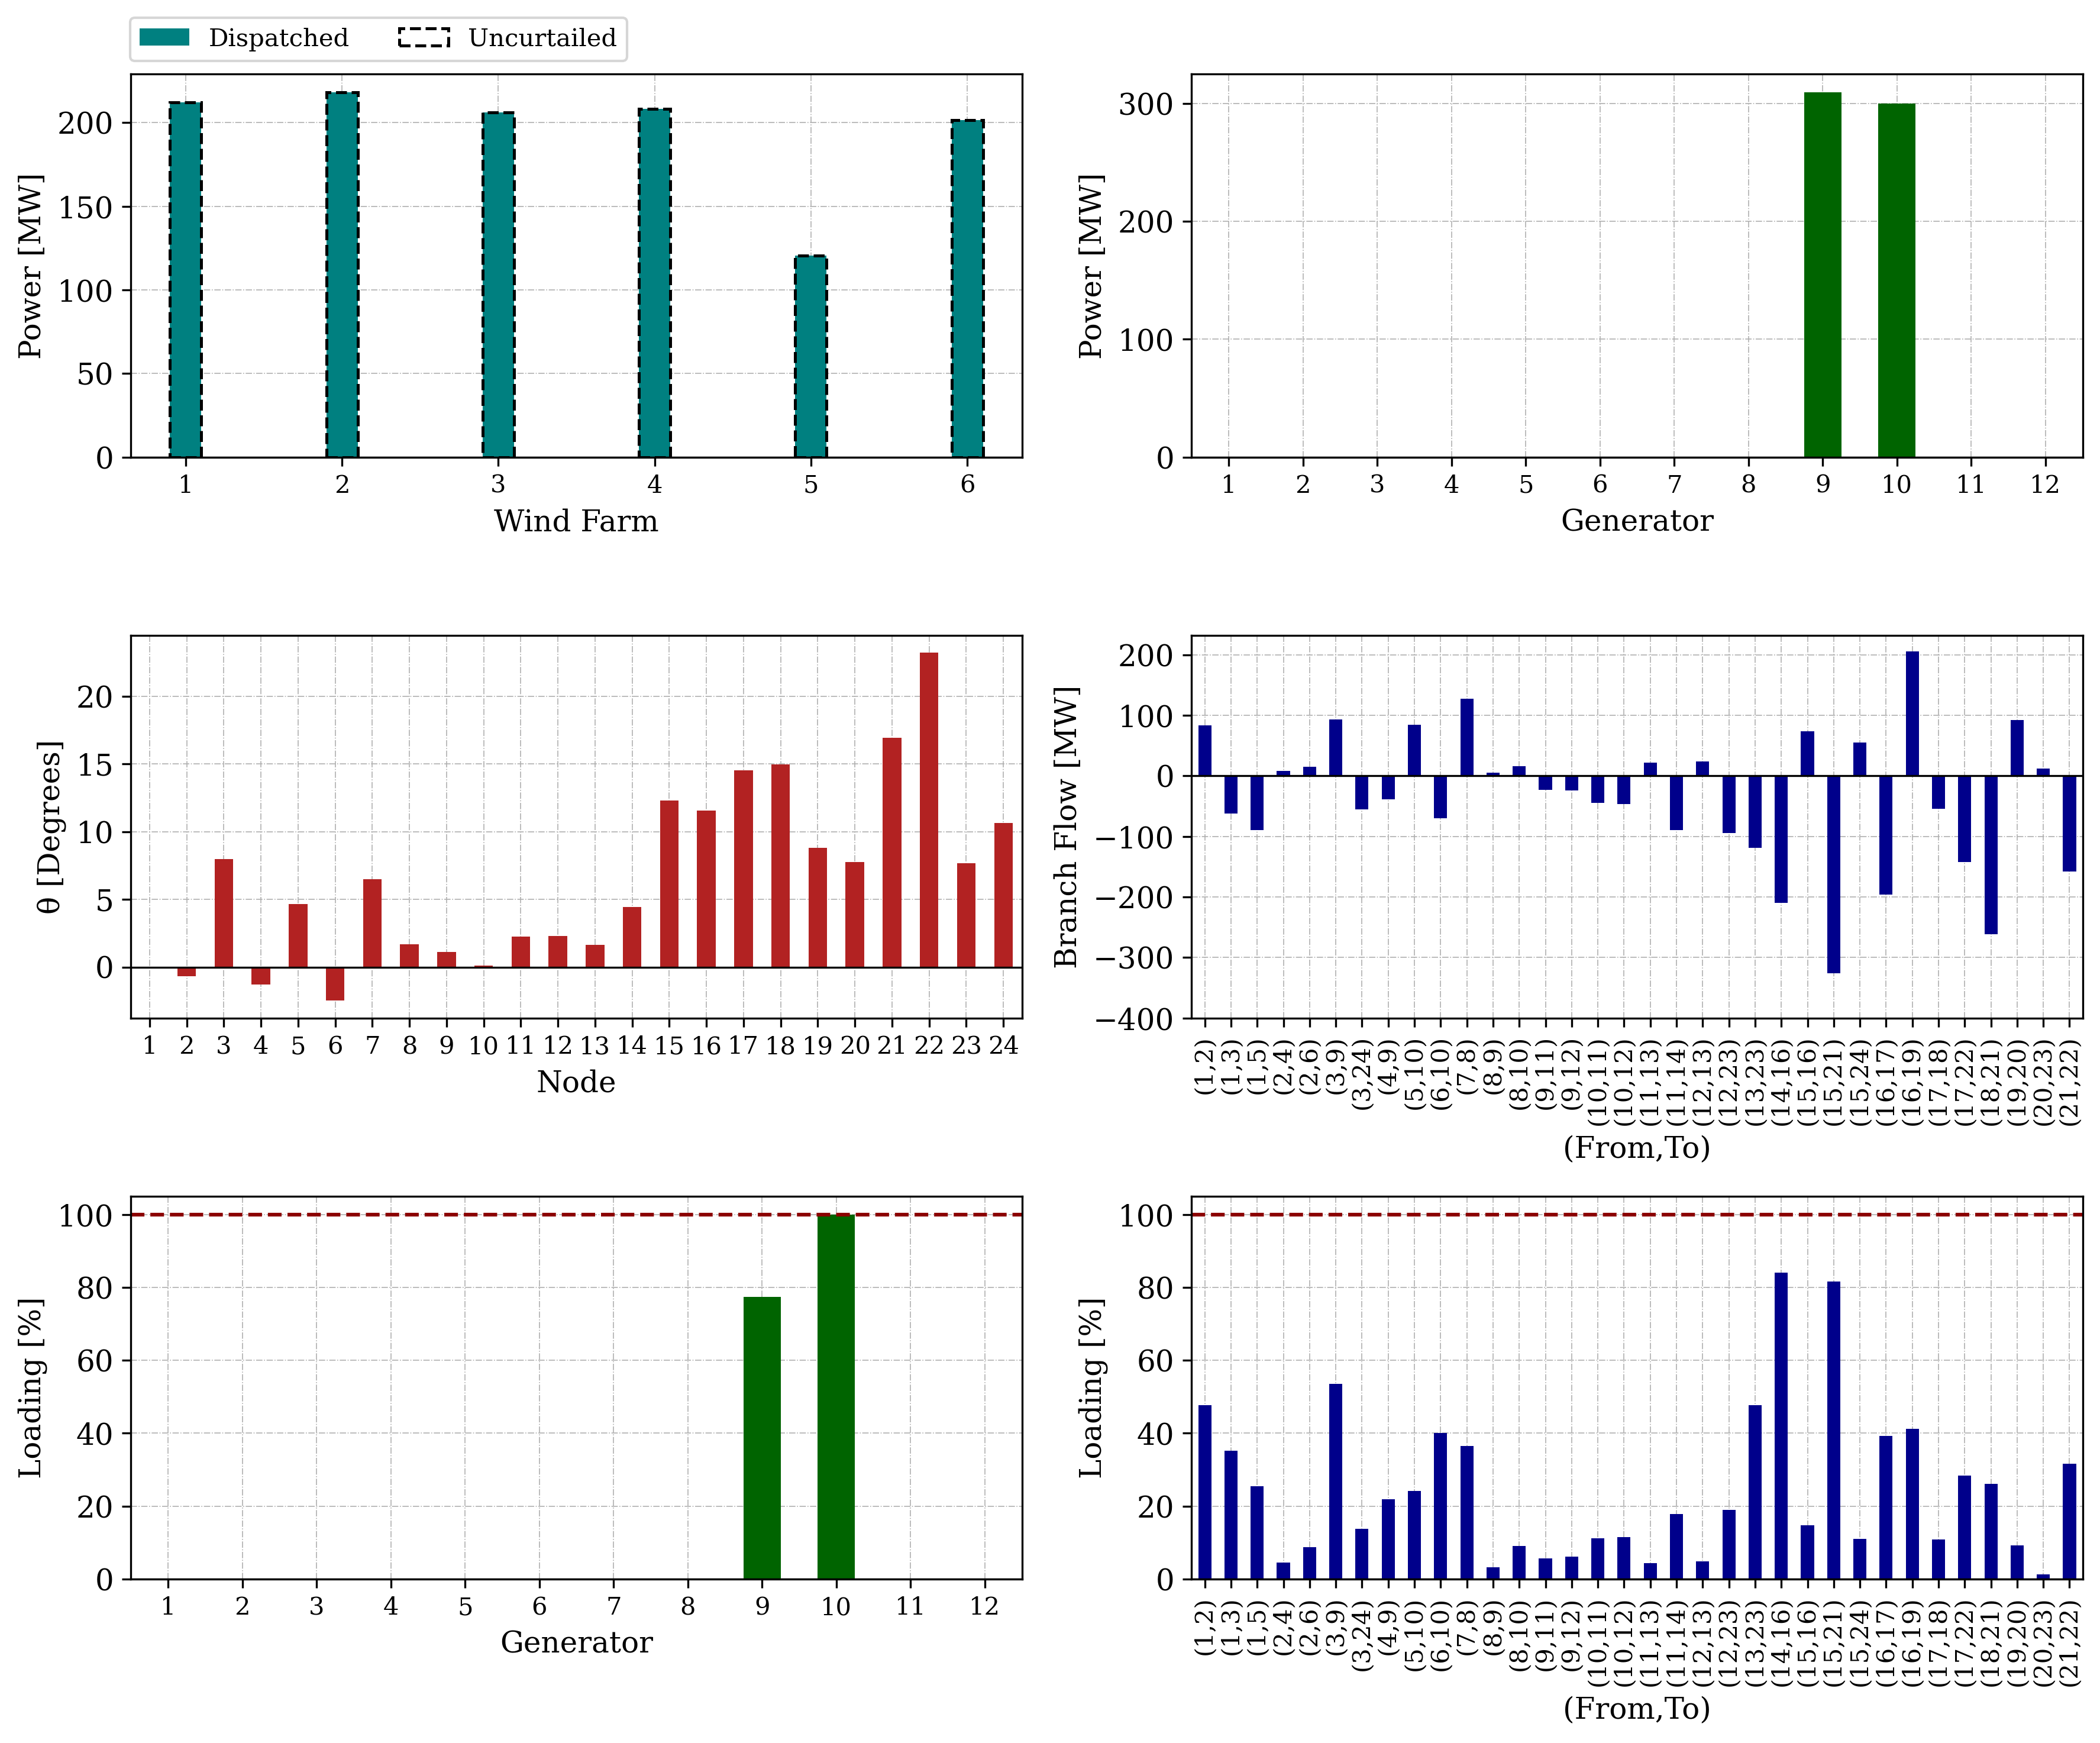

In [7]:
fig, ax = plt.subplots(3,2,figsize=( 12 , 10 ) , dpi=300) # Create the figure

flow_labels = []

for row in range(len(branch_flows)):
    label = '(' + str(branch_flows.iloc[row, 0] + 1) + ',' + str(branch_flows.iloc[row, 1] + 1) + ')'
    flow_labels.append(label)

(results.get('wind')['p_W'] * S_base_3ph).plot(kind='bar', ax=ax[0][0], color='teal', width=0.2, label='Dispatched')
(wind_data.T[t].reset_index(drop=True)).plot(kind='bar', ax=ax[0][0], color='black', width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.2, label='Uncurtailed')
ax[0][0].set_ylabel('Power [MW]')
ax[0][0].set_xlabel('Wind Farm')
ax[0][0].set_xticks(ticks = np.arange(0, len(wind_data.columns)), labels = np.arange(1, len(wind_data.columns) + 1), fontsize=10, rotation = 0)
ax[0][0].legend(loc='upper left',bbox_to_anchor=(-0.015, 1.18), ncol=2, fontsize=10)

(results.get('gen')['p_G'] * S_base_3ph).plot(kind='bar', ax=ax[0][1], color='darkgreen')
ax[0][1].set_ylabel('Power [MW]')
ax[0][1].set_xlabel('Generator')
ax[0][1].set_xticks(ticks = np.arange(0, len(gen_data)), labels = np.arange(1, len(gen_data) + 1), fontsize=10, rotation = 0)

results.get('theta')['theta_deg'].plot(kind='bar', ax=ax[1][0], color='firebrick')
ax[1][0].set_ylabel('\u03B8 [Degrees]')
ax[1][0].set_xlabel('Node')
ax[1][0].set_xticks(ticks = np.arange(0, n_bus), labels = np.arange(1, n_bus + 1), fontsize=10, rotation = 0)

(results.get('flows')['Flow'] * S_base_3ph).plot(kind='bar', ax=ax[1][1], color='darkblue')
ax[1][1].set_ylabel('Branch Flow [MW]')
ax[1][1].set_xlabel('(From,To)')
ax[1][1].set_xticks(ticks = np.arange(0, len(flow_labels), 1), labels = flow_labels, fontsize=10)
ax[1][1].set_yticks(np.arange(int(math.floor((results.get('flows')['Flow'] * S_base_3ph).min() / 100.0)) * 100, 
                              int(math.ceil((results.get('flows')['Flow'] * S_base_3ph).max() / 100.0)) * 100, 
                              100)) #nearest negative and positive 100, rounding up

(results.get('gen')['Loading Percentage']).plot(kind='bar', ax=ax[2][0], color='darkgreen')
ax[2][0].axhline(100, color='darkred', linestyle='--')
ax[2][0].set_ylabel('Loading [%]')
ax[2][0].set_xlabel('Generator')
ax[2][0].set_xticks(ticks = np.arange(0, len(gen_data)), labels = np.arange(1, len(gen_data) + 1), fontsize=10, rotation = 0)

results.get('flows')['Loading Percentage'].plot(kind='bar', ax=ax[2][1], color='darkblue')
ax[2][1].axhline(100, color='darkred', linestyle='--')
ax[2][1].set_ylabel('Loading [%]')
ax[2][1].set_xlabel('(From,To)')
ax[2][1].set_xticks(ticks = np.arange(0, len(flow_labels), 1), labels = flow_labels, fontsize=10)

for i in range(3):
    for k in range(2):
        ax[i][k].axhline(0, color='black', linewidth=0.8)
        ax[i][k].spines[['right', 'top']].set_visible(True)
        ax[i][k].set_axisbelow(True)

#plt.suptitle('Objective Value: %.1f DKK\nTotal Load: %.1f MWh\nTotal Production: %.1f MWh\n(Wind: %.1f MWh & Generators: %.1f MWh)' % (m.objVal, sum_load, sum_production, sum_wind, sum_gen), fontsize=14)

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/single_timestep_results.png',bbox_inches='tight')
plt.show()

In [24]:
gen_costs['C (DKK/MWh)']

0      93.6396
1      93.6396
2     145.5210
3     147.1379
4     183.5533
5      73.9556
6      73.9556
7      42.3206
8      38.4541
9       0.0000
10     73.9556
11     76.5567
Name: C (DKK/MWh), dtype: float64

In [ ]:
#Calculate supplier payments
mp = 38.454 #DKK

sum_revenue = 0

print('Supplier profits (revenue minus costs):')
for i in range(len(p_G)):
    gen_revenue = p_G[i].x * S_base_3ph * mp
    gen_profit = gen_revenue - p_G[i].x * S_base_3ph * gen_costs['C (DKK/MWh)'][i]
    sum_revenue += gen_revenue
    print(p_G[i].VarName + ": %.2f DKK" % gen_profit)

#wind farms have zero cost in the model
for n in range(len(p_W)):
    wf_revenue = p_W[n].x * S_base_3ph * mp
    sum_revenue += wf_revenue
    print(p_W[n].VarName + ": %.2f DKK" % wf_revenue)

print('Total supplier payments: %.2f DKK' % sum_revenue)

Supplier profits (revenue minus costs):
P_G[0]: 0.00 DKK
P_G[1]: 0.00 DKK
P_G[2]: 0.00 DKK
P_G[3]: 0.00 DKK
P_G[4]: 0.00 DKK
P_G[5]: 0.00 DKK
P_G[6]: 0.00 DKK
P_G[7]: 0.00 DKK
P_G[8]: -0.03 DKK
P_G[9]: 11536.20 DKK
P_G[10]: 0.00 DKK
P_G[11]: 0.00 DKK
P_W[0]: 8150.18 DKK
P_W[1]: 8384.36 DKK
P_W[2]: 7923.70 DKK
P_W[3]: 8005.52 DKK
P_W[4]: 4636.04 DKK
P_W[5]: 7754.58 DKK
Total supplier payments: 68287.96 DKK
